In [1]:
import functools
import numpy as np
import jax
from brax import envs
from brax.io import model, html
from brax.training.agents.apg import networks as apg_networks
from brax.training.acme import running_statistics
from diffmimic.mimic_envs import register_mimic_env
from IPython.display import HTML, clear_output
import matplotlib.pyplot as plt

In [2]:
# env
register_mimic_env()

f = '/data/benny_cai/diffmimic/A1_logs/exp_64_32_0.0003_500_0.4_0_threshold_0.2_True_66_66_66_True_0.02_1_0.5_0.01_0.01_10_jump_forward_50Hz/eval_traj_best.npy'
rollout_traj = np.load(f)

if len(rollout_traj.shape) == 3:
    seed = 0
    rollout_traj = rollout_traj[:, seed]

env = envs.get_environment(env_name="a1_mimic", reference_traj=rollout_traj)

In [3]:
# network
network_factory = functools.partial(apg_networks.make_apg_networks, hidden_layer_sizes=(512, 256))
normalize = running_statistics.normalize
apg_network = network_factory(
      env.observation_size,
      env.action_size,
      preprocess_observations_fn=normalize)

# policy
make_policy = apg_networks.make_inference_fn(apg_network)
params = model.load_params('/data/benny_cai/diffmimic/A1_logs/exp_64_32_0.0003_500_0.4_0_threshold_0.2_True_66_66_66_True_0.02_1_0.5_0.01_0.01_10_jump_forward_50Hz/params_best.pkl')
policy = make_policy(params)

In [4]:
# Visualizing a trajectory of the learned inference function
jit_env_reset = jax.jit(env.reset) # reset: retrieve the 1st state from the reference motion
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(policy)

rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)
act_list = []
for i in range(66):
    print("###########", i)
    rollout.append(state.pipeline_state)
    act_rng, rng = jax.random.split(rng)
    act, _ = jit_inference_fn(state.obs, act_rng)
    act_list.append(act)
    # print("action: ", act)
    state = jit_env_step(state, act)

########### 0
########### 1
########### 2
########### 3
########### 4
########### 5
########### 6
########### 7
########### 8
########### 9
########### 10
########### 11
########### 12
########### 13
########### 14
########### 15
########### 16
########### 17
########### 18
########### 19
########### 20
########### 21
########### 22
########### 23
########### 24
########### 25
########### 26
########### 27
########### 28
########### 29
########### 30
########### 31
########### 32
########### 33
########### 34
########### 35
########### 36
########### 37
########### 38
########### 39
########### 40
########### 41
########### 42
########### 43
########### 44
########### 45
########### 46
########### 47
########### 48
########### 49
########### 50
########### 51
########### 52
########### 53
########### 54
########### 55
########### 56
########### 57
########### 58
########### 59
########### 60
########### 61
########### 62
########### 63
########### 64
########### 65


In [5]:
HTML(html.render(env.sys.replace(dt=env.dt), rollout))

In [6]:
env.sys.link_names

['trunk',
 'FR_hip',
 'FR_thigh',
 'FR_calf',
 'FL_hip',
 'FL_thigh',
 'FL_calf',
 'RR_hip',
 'RR_thigh',
 'RR_calf',
 'RL_hip',
 'RL_thigh',
 'RL_calf']

In [7]:
act_list = np.array(act_list)
act_list.shape

(66, 12)

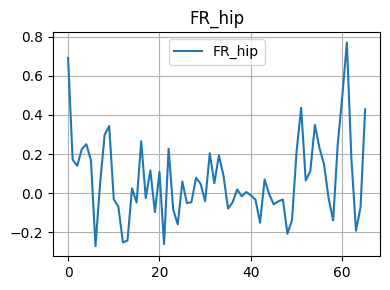

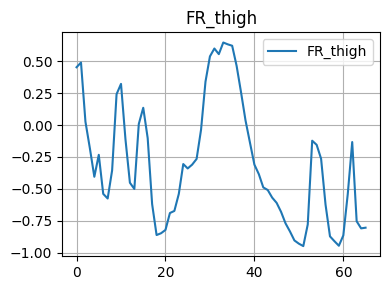

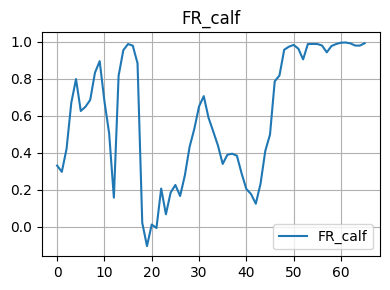

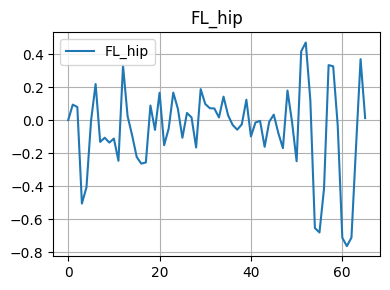

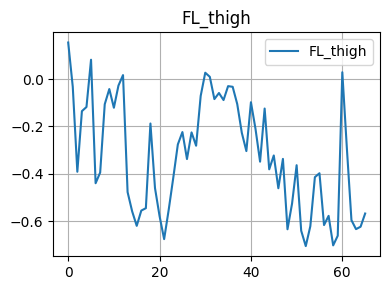

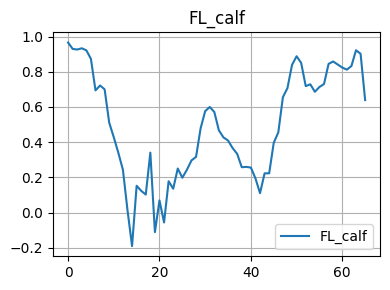

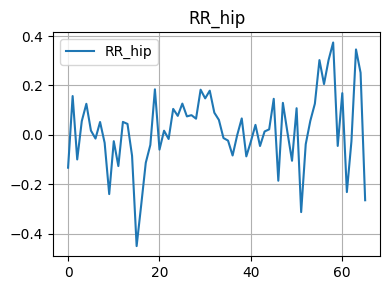

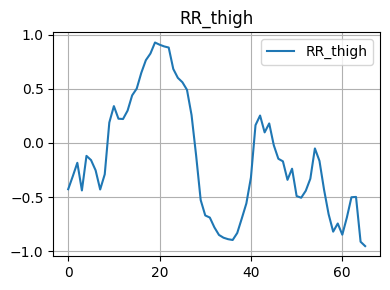

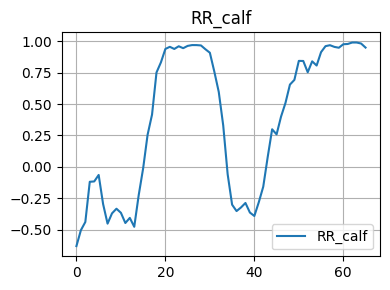

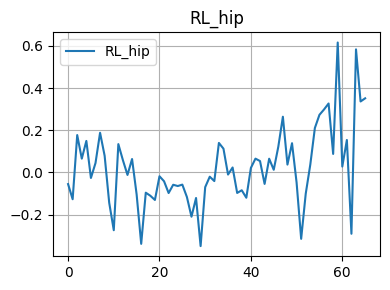

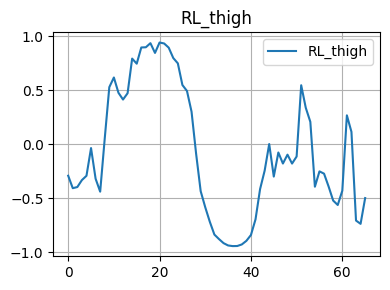

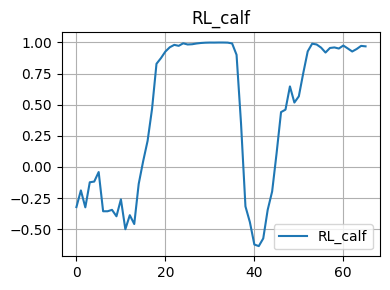

In [8]:
# visualize the actions of all actuators, in range [-1,1]
time = np.arange(66)
for i in range(12):
    link_name = env.sys.link_names[i+1]
    link_act = act_list[:,i]
    plt.figure(figsize=(4, 3))
    plt.plot(time, link_act, label=link_name)
    plt.title(link_name)
    plt.legend() 
    plt.grid(True)
    plt.tight_layout()  

In [7]:
dir(env.sys)

['T',
 '__add__',
 '__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_flax_dataclass',
 '_model',
 'act_size',
 'actuator',
 'ang_damping',
 'baumgarte_erp',
 'collide_scale',
 'concatenate',
 'density',
 'dof',
 'dof_link',
 'dof_ranges',
 'dt',
 'enable_fluid',
 'geom_masks',
 'geoms',
 'get_mjx_model',
 'get_model',
 'gravity',
 'index_set',
 'index_sum',
 'init_q',
 'joint_scale_ang',
 'joint_scale_pos',
 'link',
 'link_names',
 'link_parents',
 'link_types',
 'matrix_inv_iterations',
 'num_links',
 'q_idx',
 'q_size',
 'qd_idx',
 'qd_size',
 'rep

# random try

In [ ]:
# # Visualizing a trajectory of the learned inference function
# jit_env_reset = jax.jit(env.reset) # reset: retrieve the 1st state from the reference motion
# jit_env_step = jax.jit(env.step)
# jit_inference_fn = jax.jit(policy)

# rollout = []
# rng = jax.random.PRNGKey(seed=1)
# state = jit_env_reset(rng=rng)
# act_list = []
# for i in range(66):
#     print(i)
#     rollout.append(state.pipeline_state)
#     act_rng, rng = jax.random.split(rng)
#     act, _ = jit_inference_fn(state.obs, act_rng)
#     act_list.append(act)
#     # print("action: ", act)
#     state = jit_env_step(state, act)

In [ ]:
# HTML(html.render(env.sys.replace(dt=env.dt), rollout))